In [1]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] =  '-1'
import networkx as nx
import tensorflow as tf
from tensorflow.keras import layers
import hoomd
import hoomd.md
import hoomd.htf as htf
import numpy as np
import gsd
import gsd.hoomd
import pickle
import matplotlib.pyplot as plt

In [2]:
# building a HTF model for coarse graining
# here use the single-molecule file for simplicity
# TODO: update to get one molecule from a .gsd with multiple
#       e.g. grab first entry in htf.find_molecules(system) -> do the rest
fname = '1-length-4-peek-para-only.gsd'
gsdfile = gsd.hoomd.open(fname)
context = hoomd.context.initialize('--mode=cpu')
system = hoomd.init.read_gsd(filename=fname)
context.sorter.disable()

HOOMD-blue 2.9.3 DOUBLE HPMC_MIXED TBB SSE SSE2 SSE3 
Compiled: 01/11/2021
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, J Glaser, and S C Glotzer. "HOOMD-blue: A Python package for
  high-performance molecular dynamics and hard particle Monte Carlo
  simulations", Computational Materials Science 173 (2020) 109363
-----
HOOMD-blue is running on the CPU
notice(2): Group "all" created containing 88 particles


In [3]:
molecule_mapping_index = htf.find_molecules(system)

Finding molecules...0.00%


['ca-oh', 'ca-ca', 'ca-ca', 'ca-ca', 'ca-ca', 'ca-ca', 'ca-os', 'ca-os', 'ca-ca', 'ca-ca', 'ca-ca', 'ca-ca', 'c-ca', 'ca-ca', 'c-ca', 'c-o', 'ca-ca', 'ca-ca', 'ca-ca', 'ca-ca', 'ca-os', 'ca-os', 'ca-ca', 'ca-ca', 'ca-ca', 'ca-ca', 'ca-ca', 'ca-os', 'ca-os', 'ca-ca', 'ca-ca', 'ca-ca', 'ca-ca', 'ca-ca', 'c-ca', 'c-o', 'c-ca', 'ca-ca', 'ca-ca', 'ca-ca', 'ca-os', 'ca-ca', 'ca-os', 'ca-ca', 'ca-ca', 'ca-ca', 'ca-ca', 'ca-ca', 'ca-os', 'ca-os', 'ca-ca', 'ca-ca', 'ca-ca', 'ca-ca', 'c-ca', 'ca-ca', 'c-o', 'c-ca', 'ca-ca', 'ca-ca', 'ca-ca', 'ca-ca', 'ca-os', 'ca-os', 'ca-ca', 'ca-ca', 'ca-ca', 'ca-ca', 'ca-os', 'ca-ca', 'ca-os', 'ca-ca', 'ca-ca', 'ca-ca', 'ca-ca', 'ca-ca', 'c-ca', 'c-ca', 'c-o', 'ca-ca', 'ca-ca', 'ca-ca', 'ca-ca', 'ca-ca', 'ca-ca', 'ca-ca', 'ca-ca', 'ca-ca', 'ca-ca', 'ca-ca', 'ca-ca', 'ca-ca', 'ca-ca', 'ca-ca', 'ca-ca', 'ca-ca', 'ca-ca', 'ca-ca', 'ca-ca']
[{0, 1, 2, 3, 4, 86, 87}, {5, 6, 7, 8, 9, 84, 85}, {10, 11, 12, 13, 14, 81, 82, 83}, {15, 16, 17, 18, 80, 79, 19}, {77, 78, 

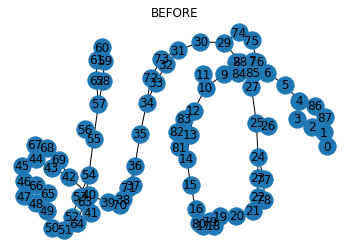

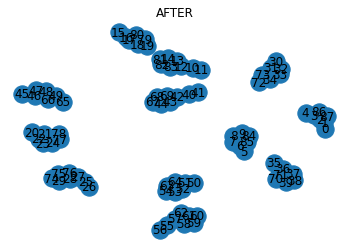

In [4]:
graph = nx.Graph()
# add all our particles and bonds
for particle in system.particles:
    graph.add_node(particle.tag, name=particle.type)
for bond in system.bonds:
    graph.add_edge(bond.a, bond.b)
plt.figure()
plt.title('BEFORE')
nx.draw(graph, with_labels=True)
# judiciously snip bonds
degrees_dict = dict(graph.degree())

print([item.type for item in list(system.bonds)])

for i, bond in enumerate(system.bonds):
    if bond.type == 'c-ca' or bond.type == 'ca-c':
        if degrees_dict[bond.a] == 3 and degrees_dict[bond.b] == 3:
            graph.remove_edge(bond.a, bond.b)
    elif bond.type == 'ca-os' or bond.type == 'os-ca':
        if degrees_dict[bond.a] == 2 and degrees_dict[bond.b] == 3 or\
        degrees_dict[bond.a] == 3 and degrees_dict[bond.b] == 2:
            graph.remove_edge(bond.a, bond.b)
    degrees_dict = dict(graph.degree())

subgraph_list = list(nx.connected_components(graph))
print(subgraph_list, len(subgraph_list))
print(type(subgraph_list[0]))
plt.figure()
plt.title('AFTER')
nx.draw(graph, with_labels=True)

In [5]:
# now we have our beads grouped up, we need to get their mapping
# get total N atoms
N = sum([len(m) for m in molecule_mapping_index])
# get molecule count
M = len(molecule_mapping_index)
# atoms per molecule
MN = len(molecule_mapping_index[0])
print('N_atoms:', N,'\nN_molecules:', M,'\nN_atoms_per_molecule:', MN)
# make sure we didn't miss any particles
assert(sum([len(item) for item in subgraph_list]) == MN)
print(len(subgraph_list))

N_atoms: 88 
N_molecules: 1 
N_atoms_per_molecule: 88
12


In [6]:
# create a mapping for our molecules
# these are 4-monomer polymers, and we're doing 3 beads per monomer
# therefore, we need a 12 x 88 matrix


mapping_arr = np.zeros((12,MN))

for i, subgraph in enumerate(subgraph_list):
    for atom_idx in subgraph:
        mapping_arr[i][atom_idx] = 1
        
N = sum([len(m) for m in molecule_mapping_index])
# get molecule count
M = len(molecule_mapping_index)
# atoms per molecule
MN = len(molecule_mapping_index[0])
print('N_atoms:', N,'\nN_molecules:', M,'\nN_atoms_per_molecule:', MN)
# again make sure we didn't miss any atoms
assert(np.sum(mapping_arr) == MN)

bead_number = mapping_arr.shape[0]



N_atoms: 88 
N_molecules: 1 
N_atoms_per_molecule: 88


In [7]:
fname = '100-length-4-peek-para-only-production.gsd'
gsdfile = gsd.hoomd.open(fname)
context = hoomd.context.initialize('--mode=cpu')
system = hoomd.init.read_gsd(filename=fname)
context.sorter.disable()
set_rcut = 11.0
molecule_mapping_index = htf.find_molecules(system)

cg_mapping = htf.sparse_mapping([mapping_arr for _ in molecule_mapping_index],
                               molecule_mapping_index, system=system)
N = sum([len(m) for m in molecule_mapping_index])
# get molecule count
M = len(molecule_mapping_index)
# atoms per molecule
MN = len(molecule_mapping_index[0])
print('N_atoms:', N,'\nN_molecules:', M,'\nN_atoms_per_molecule:', MN)
assert cg_mapping.shape == (M * bead_number, N)

notice(2): Group "all" created containing 8800 particles
Finding molecules...99.00%
N_atoms: 8800 
N_molecules: 100 
N_atoms_per_molecule: 88


In [8]:
import MDAnalysis as mda
univ = mda.Universe(fname)

In [9]:
set(univ.atoms.types)

{'c', 'ca', 'o', 'oh', 'os'}

In [10]:
class TrajModel(htf.SimModel):
    def setup(self, CG_NN, cg_mapping, rcut):
        self.CG_NN = CG_NN
        self.cg_mapping = cg_mapping
        self.rcut = rcut
        #self.avg_aa_rdf = tf.keras.metrics.MeanTensor() # all atoms
        self.avg_cg_rdf = tf.keras.metrics.MeanTensor() # CG beads
        #self.avg_cc_rdf = tf.keras.metrics.MeanTensor() # just  C-C
        #self.avg_co_rdf = tf.keras.metrics.MeanTensor() # just C-O
        #self.avg_oo_rdf = tf.keras.metrics.MeanTensor() # just O-O
    def compute(self, nlist, positions, box):        
        # get RDF
        # calculate the center of mass of a CG bead
        box_size = htf.box_size(box)
        mapped_pos = htf.center_of_mass(positions[:,:3], self.cg_mapping, box_size)
        print('made it past to mapped_pos')
        # create the mapped neighbot list
        mapped_nlist = htf.compute_nlist(mapped_pos, self.rcut, self.CG_NN, box_size, True)
        print('made it past mapped_nlist')
        # compute RDF for mapped and C-C in all-atom
        cg_rdf = htf.compute_rdf(mapped_nlist, [0.1, self.rcut])
        print('made it past cg_rdf')
        #aa_rdf = htf.compute_rdf(nlist, [0.1, self.rcut], positions[:,3], type_i=1, type_j=1)
        #print('made it past aa_rdf')
        # compute ca-o (?) RDF
        #cordf = htf.compute_rdf(
        #    nlist, [0.1,self.rcut], positions[:, 3], 
        #    nbins=50, type_i=1, type_j=2)
        # compute ca-ca(?) RDF
        #ccrdf = htf.compute_rdf(
        #    nlist,[0.1,self.rcut],  positions[:, 3], 
        #    nbins=50, type_i=0, type_j=0)
        #oordf = htf.compute_rdf(
        #    nlist,[0.1,self.rcut],  positions[:, 3], 
        #    nbins=50, type_i=2, type_j=4)
        # average the RDFs
        self.avg_cg_rdf.update_state(cg_rdf)
        print('made it past avg_cg_rdf')
        #self.avg_aa_rdf.update_state(aa_rdf)
        #print('made it past avg_aa_rdf')
        #self.avg_cc_rdf.update_state(ccrdf)
        #self.avg_co_rdf.update_state(cordf)
        #self.avg_oo_rdf.update_state(oordf)
        return 
nneighbor_cutoff = 32
model = TrajModel(nneighbor_cutoff,
                 CG_NN = nneighbor_cutoff,
                 cg_mapping=cg_mapping,
                 output_forces=False,
                 rcut=set_rcut,
                 check_nlist=False)

In [ ]:
i = 0
for inputs, ts in htf.iter_from_trajectory(nneighbor_cutoff, univ, r_cut=set_rcut):
    print(i)
    i+=1
    result = model(inputs)

0
made it past to mapped_pos
made it past mapped_nlist
made it past cg_rdf
made it past avg_cg_rdf
made it past to mapped_pos
made it past mapped_nlist


In [ ]:
start_idx = 0

ccrdf = model.avg_ccrdf.result().numpy()
plt.figure()
plt.plot(ccrdf[1, start_idx:], ccrdf[0, start_idx:], label='C-C', color='C1')
plt.title(r'C-C RDF')
plt.xlabel(r'r')
plt.ylabel(r'g(r)')
plt.legend()
plt.show()

cordf = model.avg_cordf.result().numpy()
plt.figure()
plt.plot(ccrdf[1, start_idx:], cordf[0, start_idx:], label='C-O', color='C1')
plt.title(r'C-O RDF')
plt.xlabel(r'r')
plt.ylabel(r'g(r)')
plt.legend()
plt.show()

cordf = model.avg_oordf.result().numpy()
plt.figure()
plt.plot(ccrdf[1, start_idx:], cordf[0, start_idx:], label='C-O', color='C1')
plt.title(r'C-O RDF')
plt.xlabel(r'r')
plt.ylabel(r'g(r)')
plt.legend()
plt.show()